In [43]:
import os 
import time
import functools
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [44]:
def tensor_to_image(tensor):
    tensor=np.array(tensor*255,dtype=np.unit8)

    if np.ndim(tensor)>3:
        tensor = tensor[0]
    else:
        raise Exception()

    return Image.fromarray(tensor)


In [46]:
def load_image(imagepath):
    max_res=512
    image=tf.io.read_file(imagepath)
    image=tf.image.decode_image(image,channels=3)
    image=tf.image.convert_image_dtype(image,tf.float32)
    shape=tf.cast(tf.shape(image)[:,-1],tf.float32)
    long_side=max(shape)
    scaling_factor=max_res/long_side
    new_shape=tf.cast(shape*scaling_factor,tf.float32)
    image=tf.image.resize(image,new_Shape)
    image=image[tf.newaxis,:]
    return image

  0%|          | 1/300 [00:02<13:30,  2.71s/it]

Step 0: Loss = 8.3288


 17%|█▋        | 51/300 [02:26<12:12,  2.94s/it]

Step 50: Loss = 5.8768


 34%|███▎      | 101/300 [04:50<09:40,  2.92s/it]

Step 100: Loss = 5.8521


 50%|█████     | 151/300 [07:15<07:15,  2.93s/it]

Step 150: Loss = 5.8419


 67%|██████▋   | 201/300 [09:39<04:49,  2.92s/it]

Step 200: Loss = 5.8358


 84%|████████▎ | 251/300 [12:04<02:23,  2.92s/it]

Step 250: Loss = 5.8319


100%|██████████| 300/300 [14:25<00:00,  2.89s/it]


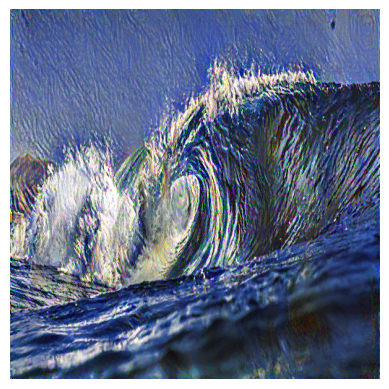

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512 if torch.cuda.is_available() else 256  # Reduce size for speed

# Image Preprocessing
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load image function
def load_img(path):
    img = Image.open(path).convert('RGB')
    img = loader(img).unsqueeze(0).to(device)
    return img

# Gram Matrix computation (optimized for batch processing)
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, -1)  # Flatten spatial dimensions
    return torch.bmm(features, features.transpose(1, 2)) / (c * h * w)

# Loss functions
def content_loss(target, content):
    return torch.mean((target - content) ** 2)

def style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# VGG Model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers = ['0', '5', '10', '19', '28']  # Use fewer layers for speed
        self.vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layers:
                features.append(x)
        return features

# Load model
vgg = VGG()

# Load images
content_img = load_img("/kaggle/input/nkjnkjnko/pexels-earano-1330219.jpg")
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")
target_img = content_img.clone().requires_grad_(True)

# Optimizer (Use L-BFGS for faster convergence)
optimizer = optim.LBFGS([target_img])

# Precompute Content & Style Features (avoids redundant calculations)
with torch.no_grad():
    content_features = vgg(content_img)
    style_features = vgg(style_img)

# Hyperparameters
steps = 300  # Reduce steps for speed
alpha = 1
beta = 1e5

# Optimization loop
def closure():
    optimizer.zero_grad()
    target_features = vgg(target_img)
    
    # Compute losses
    c_loss = content_loss(target_features[2], content_features[2])  # Use middle layer for content
    s_loss = sum(style_loss(t, s) for t, s in zip(target_features, style_features))
    
    total_loss = alpha * c_loss + beta * s_loss
    total_loss.backward()
    return total_loss

# Training
for step in tqdm(range(steps)):
    optimizer.step(closure)
    if step % 50 == 0:
        print(f'Step {step}: Loss = {closure().item():.4f}')

# Convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
             torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Denormalize
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# Show final image
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.show()

  0%|          | 1/300 [00:02<13:30,  2.71s/it]

Step 0: Loss = 9.2474


 17%|█▋        | 51/300 [02:26<12:10,  2.94s/it]

Step 50: Loss = 6.1591


 34%|███▎      | 101/300 [04:51<09:41,  2.92s/it]

Step 100: Loss = 6.1353


 50%|█████     | 151/300 [07:15<07:16,  2.93s/it]

Step 150: Loss = 6.1251


 67%|██████▋   | 201/300 [09:40<04:50,  2.93s/it]

Step 200: Loss = 6.1191


 84%|████████▎ | 251/300 [12:05<02:23,  2.92s/it]

Step 250: Loss = 6.1150


100%|██████████| 300/300 [14:26<00:00,  2.89s/it]


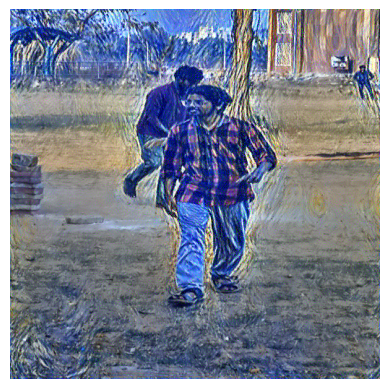

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512 if torch.cuda.is_available() else 256  # Reduce size for speed

# Image Preprocessing
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load image function
def load_img(path):
    img = Image.open(path).convert('RGB')
    img = loader(img).unsqueeze(0).to(device)
    return img

# Gram Matrix computation (optimized for batch processing)
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, -1)  # Flatten spatial dimensions
    return torch.bmm(features, features.transpose(1, 2)) / (c * h * w)

# Loss functions
def content_loss(target, content):
    return torch.mean((target - content) ** 2)

def style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# VGG Model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers = ['0', '5', '10', '19', '28']  # Use fewer layers for speed
        self.vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layers:
                features.append(x)
        return features

# Load model
vgg = VGG()

# Load images
content_img = load_img("/kaggle/input/chintu/WhatsApp Image 2025-03-12 at 09.17.52.jpeg")
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")
target_img = content_img.clone().requires_grad_(True)

# Optimizer (Use L-BFGS for faster convergence)
optimizer = optim.LBFGS([target_img])

# Precompute Content & Style Features (avoids redundant calculations)
with torch.no_grad():
    content_features = vgg(content_img)
    style_features = vgg(style_img)

# Hyperparameters
steps = 300  # Reduce steps for speed
alpha = 1
beta = 1e5

# Optimization loop
def closure():
    optimizer.zero_grad()
    target_features = vgg(target_img)
    
    # Compute losses
    c_loss = content_loss(target_features[2], content_features[2])  # Use middle layer for content
    s_loss = sum(style_loss(t, s) for t, s in zip(target_features, style_features))
    
    total_loss = alpha * c_loss + beta * s_loss
    total_loss.backward()
    return total_loss

# Training
for step in tqdm(range(steps)):
    optimizer.step(closure)
    if step % 50 == 0:
        print(f'Step {step}: Loss = {closure().item():.4f}')

# Convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
             torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Denormalize
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# Show final image
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.show()

  0%|          | 6/3000 [00:00<02:34, 19.35it/s]

Step 0: Content Loss = 0.0000, Style Loss = 0.0003, TV Loss = 0.2178


  4%|▎         | 106/3000 [00:09<03:55, 12.29it/s]

Step 100: Content Loss = 8.8465, Style Loss = 0.0000, TV Loss = 0.5153


  7%|▋         | 206/3000 [00:18<03:56, 11.82it/s]

Step 200: Content Loss = 9.5612, Style Loss = 0.0000, TV Loss = 0.5600


 10%|█         | 306/3000 [00:27<03:52, 11.59it/s]

Step 300: Content Loss = 9.8805, Style Loss = 0.0000, TV Loss = 0.5792


 14%|█▎        | 406/3000 [00:37<03:48, 11.37it/s]

Step 400: Content Loss = 10.0544, Style Loss = 0.0000, TV Loss = 0.5891


 17%|█▋        | 506/3000 [00:47<03:40, 11.29it/s]

Step 500: Content Loss = 10.1565, Style Loss = 0.0000, TV Loss = 0.5947


 20%|██        | 606/3000 [00:56<03:25, 11.66it/s]

Step 600: Content Loss = 10.2195, Style Loss = 0.0000, TV Loss = 0.5981


 24%|██▎       | 706/3000 [01:06<03:14, 11.79it/s]

Step 700: Content Loss = 10.2592, Style Loss = 0.0000, TV Loss = 0.6002


 27%|██▋       | 806/3000 [01:15<03:04, 11.86it/s]

Step 800: Content Loss = 10.2845, Style Loss = 0.0000, TV Loss = 0.6015


 30%|███       | 906/3000 [01:24<02:56, 11.86it/s]

Step 900: Content Loss = 10.3006, Style Loss = 0.0000, TV Loss = 0.6023


 34%|███▎      | 1006/3000 [01:34<02:49, 11.77it/s]

Step 1000: Content Loss = 10.3110, Style Loss = 0.0000, TV Loss = 0.6028


 37%|███▋      | 1106/3000 [01:43<02:42, 11.69it/s]

Step 1100: Content Loss = 10.3177, Style Loss = 0.0000, TV Loss = 0.6032


 40%|████      | 1206/3000 [01:52<02:34, 11.64it/s]

Step 1200: Content Loss = 10.3220, Style Loss = 0.0000, TV Loss = 0.6034


 44%|████▎     | 1306/3000 [02:02<02:25, 11.68it/s]

Step 1300: Content Loss = 10.3248, Style Loss = 0.0000, TV Loss = 0.6035


 47%|████▋     | 1406/3000 [02:11<02:16, 11.69it/s]

Step 1400: Content Loss = 10.3266, Style Loss = 0.0000, TV Loss = 0.6036


 50%|█████     | 1506/3000 [02:21<02:07, 11.70it/s]

Step 1500: Content Loss = 10.3277, Style Loss = 0.0000, TV Loss = 0.6037


 54%|█████▎    | 1606/3000 [02:30<01:58, 11.75it/s]

Step 1600: Content Loss = 10.3284, Style Loss = 0.0000, TV Loss = 0.6037


 57%|█████▋    | 1706/3000 [02:39<01:50, 11.75it/s]

Step 1700: Content Loss = 10.3289, Style Loss = 0.0000, TV Loss = 0.6037


 60%|██████    | 1806/3000 [02:49<01:41, 11.71it/s]

Step 1800: Content Loss = 10.3292, Style Loss = 0.0000, TV Loss = 0.6038


 64%|██████▎   | 1906/3000 [02:58<01:33, 11.67it/s]

Step 1900: Content Loss = 10.3294, Style Loss = 0.0000, TV Loss = 0.6038


 67%|██████▋   | 2006/3000 [03:07<01:25, 11.67it/s]

Step 2000: Content Loss = 10.3295, Style Loss = 0.0000, TV Loss = 0.6038


 70%|███████   | 2106/3000 [03:17<01:16, 11.70it/s]

Step 2100: Content Loss = 10.3296, Style Loss = 0.0000, TV Loss = 0.6038


 74%|███████▎  | 2206/3000 [03:26<01:07, 11.72it/s]

Step 2200: Content Loss = 10.3296, Style Loss = 0.0000, TV Loss = 0.6038


 77%|███████▋  | 2306/3000 [03:35<00:59, 11.72it/s]

Step 2300: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 80%|████████  | 2406/3000 [03:45<00:50, 11.77it/s]

Step 2400: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 84%|████████▎ | 2506/3000 [03:54<00:42, 11.74it/s]

Step 2500: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 87%|████████▋ | 2606/3000 [04:03<00:33, 11.72it/s]

Step 2600: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 90%|█████████ | 2706/3000 [04:13<00:25, 11.73it/s]

Step 2700: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 94%|█████████▎| 2806/3000 [04:22<00:16, 11.74it/s]

Step 2800: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


 97%|█████████▋| 2906/3000 [04:32<00:08, 11.69it/s]

Step 2900: Content Loss = 10.3297, Style Loss = 0.0000, TV Loss = 0.6038


100%|██████████| 3000/3000 [04:40<00:00, 10.68it/s]


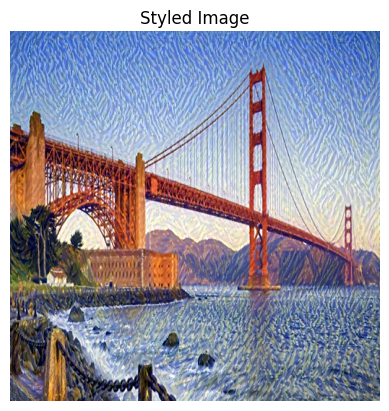

In [58]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Processing
img_size = 512 if torch.cuda.is_available() else 256  # Use larger size for better details
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # VGG normalization
])

# Function to Load and Preprocess Image
def load_img(path):
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)
    return img.to(device)

# Function to Convert Tensor to Image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  # Reverse normalization
    tensor = torch.clamp(tensor, 0, 1)  # Clip values to valid range
    return transforms.ToPILImage()(tensor)

# Content Loss (Mean Squared Error)
def get_content_loss(target, content):
    return torch.mean((target - content) ** 2)

# Gram Matrix for Style Loss
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)  # Normalize

# Style Loss Function
def get_style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# Total Variation Loss (Removes noise & artifacts)
def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

# VGG Feature Extractor (Using Pretrained VGG-19)
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.select_features = ["0", "5", "10", "19", "28"]  # Extract from deeper layers
        self.vgg = models.vgg19(pretrained=True).features.eval()  # Load pre-trained model
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select_features:
                features.append(x)
        return features

# Load Model and Images
vgg = VGG().to(device)
content_img = load_img("/kaggle/input/neuralstyle/gold.jpg")  # Replace with your content image path
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")  # Replace with your style image path
target_img = content_img.clone().requires_grad_(True)  # Start with content image

# Optimizer
optimizer = optim.Adam([target_img], lr=0.01)

# **Hyperparameters**
steps = 3000  # More iterations improve quality
alpha = 1  # Content weight
beta = 1e15  # Style weight (Increased for stronger style influence)
tv_weight = 1e-2  # Helps remove artifacts

# Extract Features
content_features = vgg(content_img)
style_features = vgg(style_img)

# **Optimization Loop**
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    target_features = vgg(target_img)
    
    # Content Loss (Using Relu_4_2 Features)
    c_loss = get_content_loss(target_features[2], content_features[2])  
    
    # Style Loss (Summed over all selected layers)
    s_loss = sum(get_style_loss(target, style) for target, style in zip(target_features, style_features))
    
    # Total Variation Loss
    tv_loss = total_variation_loss(target_img)
    
    # Total Loss
    total_loss = alpha * c_loss + beta * s_loss + tv_weight * tv_loss
    total_loss.backward()
    
    # Adjust Learning Rate Slowly
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.995  # Gradual LR decay
    
    optimizer.step()

    if step % 100 == 0:  # Print every 100 steps
        print(f"Step {step}: Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}, TV Loss = {tv_loss.item():.4f}")

# **Show Final Image**
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.title("Styled Image")
plt.show()

  0%|          | 7/3000 [00:00<02:18, 21.61it/s]

Step 0: Content Loss = 0.0000, Style Loss = 0.0003, TV Loss = 0.6444


  4%|▎         | 107/3000 [00:09<03:48, 12.64it/s]

Step 100: Content Loss = 10.3871, Style Loss = 0.0000, TV Loss = 0.6444


  7%|▋         | 207/3000 [00:18<03:41, 12.62it/s]

Step 200: Content Loss = 11.1139, Style Loss = 0.0000, TV Loss = 0.6444


 10%|█         | 307/3000 [00:27<03:38, 12.34it/s]

Step 300: Content Loss = 11.5070, Style Loss = 0.0000, TV Loss = 0.6444


 14%|█▎        | 407/3000 [00:36<03:35, 12.06it/s]

Step 400: Content Loss = 11.7832, Style Loss = 0.0000, TV Loss = 0.6444


 17%|█▋        | 507/3000 [00:46<03:32, 11.73it/s]

Step 500: Content Loss = 11.9936, Style Loss = 0.0000, TV Loss = 0.6444


 20%|██        | 607/3000 [00:55<03:19, 11.98it/s]

Step 600: Content Loss = 12.1615, Style Loss = 0.0000, TV Loss = 0.6444


 24%|██▎       | 707/3000 [01:05<03:07, 12.26it/s]

Step 700: Content Loss = 12.2997, Style Loss = 0.0000, TV Loss = 0.6444


 27%|██▋       | 807/3000 [01:14<02:56, 12.40it/s]

Step 800: Content Loss = 12.4173, Style Loss = 0.0000, TV Loss = 0.6444


 30%|███       | 907/3000 [01:23<02:48, 12.42it/s]

Step 900: Content Loss = 12.5225, Style Loss = 0.0000, TV Loss = 0.6444


 34%|███▎      | 1007/3000 [01:33<02:40, 12.40it/s]

Step 1000: Content Loss = 12.6165, Style Loss = 0.0000, TV Loss = 0.6444


 37%|███▋      | 1107/3000 [01:42<02:33, 12.37it/s]

Step 1100: Content Loss = 12.7009, Style Loss = 0.0000, TV Loss = 0.6444


 40%|████      | 1207/3000 [01:51<02:25, 12.36it/s]

Step 1200: Content Loss = 12.7791, Style Loss = 0.0000, TV Loss = 0.6444


 44%|████▎     | 1307/3000 [02:00<02:17, 12.31it/s]

Step 1300: Content Loss = 12.8511, Style Loss = 0.0000, TV Loss = 0.6444


 47%|████▋     | 1407/3000 [02:10<02:09, 12.29it/s]

Step 1400: Content Loss = 12.9159, Style Loss = 0.0000, TV Loss = 0.6444


 50%|█████     | 1507/3000 [02:19<02:01, 12.27it/s]

Step 1500: Content Loss = 12.9751, Style Loss = 0.0000, TV Loss = 0.6444


 54%|█████▎    | 1607/3000 [02:28<01:53, 12.30it/s]

Step 1600: Content Loss = 13.0307, Style Loss = 0.0000, TV Loss = 0.6444


 57%|█████▋    | 1707/3000 [02:37<01:45, 12.29it/s]

Step 1700: Content Loss = 13.0823, Style Loss = 0.0000, TV Loss = 0.6444


 60%|██████    | 1807/3000 [02:47<01:37, 12.26it/s]

Step 1800: Content Loss = 13.1309, Style Loss = 0.0000, TV Loss = 0.6444


 64%|██████▎   | 1907/3000 [02:56<01:28, 12.30it/s]

Step 1900: Content Loss = 13.1759, Style Loss = 0.0000, TV Loss = 0.6444


 67%|██████▋   | 2007/3000 [03:05<01:20, 12.29it/s]

Step 2000: Content Loss = 13.2181, Style Loss = 0.0000, TV Loss = 0.6444


 70%|███████   | 2107/3000 [03:15<01:12, 12.33it/s]

Step 2100: Content Loss = 13.2579, Style Loss = 0.0000, TV Loss = 0.6444


 74%|███████▎  | 2207/3000 [03:24<01:04, 12.33it/s]

Step 2200: Content Loss = 13.2974, Style Loss = 0.0000, TV Loss = 0.6444


 77%|███████▋  | 2307/3000 [03:33<00:56, 12.32it/s]

Step 2300: Content Loss = 13.3326, Style Loss = 0.0000, TV Loss = 0.6444


 80%|████████  | 2407/3000 [03:42<00:48, 12.35it/s]

Step 2400: Content Loss = 13.3642, Style Loss = 0.0000, TV Loss = 0.6444


 84%|████████▎ | 2507/3000 [03:52<00:39, 12.33it/s]

Step 2500: Content Loss = 13.3938, Style Loss = 0.0000, TV Loss = 0.6444


 87%|████████▋ | 2607/3000 [04:01<00:31, 12.33it/s]

Step 2600: Content Loss = 13.4240, Style Loss = 0.0000, TV Loss = 0.6444


 90%|█████████ | 2707/3000 [04:10<00:23, 12.35it/s]

Step 2700: Content Loss = 13.4524, Style Loss = 0.0000, TV Loss = 0.6444


 94%|█████████▎| 2807/3000 [04:20<00:15, 12.34it/s]

Step 2800: Content Loss = 13.4813, Style Loss = 0.0000, TV Loss = 0.6444


 97%|█████████▋| 2907/3000 [04:29<00:07, 12.34it/s]

Step 2900: Content Loss = 13.5119, Style Loss = 0.0000, TV Loss = 0.6444


100%|██████████| 3000/3000 [04:37<00:00, 10.80it/s]


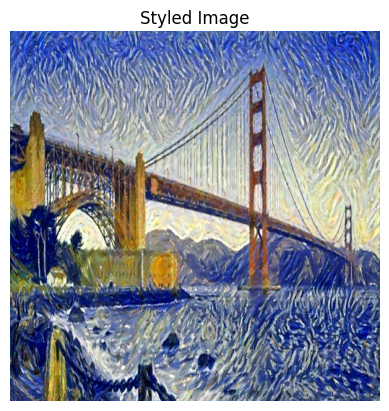

In [67]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Processing
img_size = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to Load Image
def load_img(path):
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)
    return img.to(device)

# Convert Tensor to Image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# Loss Functions
def get_content_loss(target, content):
    return torch.mean((target - content) ** 2)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

def get_style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# Total Variation Loss
def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

# Load Pretrained VGG Model
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.select_features = ["0", "5", "10", "19", "28"]
        self.vgg = models.vgg19(pretrained=True).features.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select_features:
                features.append(x)
        return features

# Load Model and Images
vgg = VGG().to(device)
content_img = load_img("/kaggle/input/neuralstyle/gold.jpg")
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")

target_img = content_img.clone().requires_grad_(True)

# Optimizer
optimizer = optim.Adam([target_img], lr=0.02)

# Hyperparameters
steps = 3000
alpha = 1
beta = 100000000000000


# Extract Features
content_features = vgg(content_img)
style_features = vgg(style_img)

# **Optimization Loop**
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    target_features = vgg(target_img)
    
    c_loss = get_content_loss(target_features[2], content_features[2])  
    s_loss = sum(get_style_loss(target, style) for target, style in zip(target_features, style_features))
   
    
    total_loss = alpha * c_loss + beta * s_loss 
    total_loss.backward()
    
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.99995  
    
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}, TV Loss = {tv_loss.item():.4f}")

# Show Final Image
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.title("Styled Image")
plt.show()

  0%|          | 7/3000 [00:00<02:07, 23.44it/s]

Step 0: Content Loss = 0.0000, Style Loss = 0.0004, TV Loss = 0.6444


  4%|▎         | 107/3000 [00:09<03:50, 12.57it/s]

Step 100: Content Loss = 10.3085, Style Loss = 0.0000, TV Loss = 0.6444


  7%|▋         | 207/3000 [00:18<03:47, 12.30it/s]

Step 200: Content Loss = 10.6450, Style Loss = 0.0000, TV Loss = 0.6444


 10%|█         | 307/3000 [00:27<03:43, 12.03it/s]

Step 300: Content Loss = 10.8120, Style Loss = 0.0000, TV Loss = 0.6444


 14%|█▎        | 407/3000 [00:37<03:41, 11.73it/s]

Step 400: Content Loss = 10.9226, Style Loss = 0.0000, TV Loss = 0.6444


 17%|█▋        | 507/3000 [00:47<03:27, 12.02it/s]

Step 500: Content Loss = 11.0039, Style Loss = 0.0000, TV Loss = 0.6444


 20%|██        | 607/3000 [00:56<03:15, 12.26it/s]

Step 600: Content Loss = 11.0711, Style Loss = 0.0000, TV Loss = 0.6444


 24%|██▎       | 707/3000 [01:05<03:05, 12.39it/s]

Step 700: Content Loss = 11.1281, Style Loss = 0.0000, TV Loss = 0.6444


 27%|██▋       | 807/3000 [01:15<02:55, 12.46it/s]

Step 800: Content Loss = 11.1774, Style Loss = 0.0000, TV Loss = 0.6444


 30%|███       | 907/3000 [01:24<02:48, 12.45it/s]

Step 900: Content Loss = 11.2223, Style Loss = 0.0000, TV Loss = 0.6444


 34%|███▎      | 1007/3000 [01:33<02:41, 12.37it/s]

Step 1000: Content Loss = 11.2625, Style Loss = 0.0000, TV Loss = 0.6444


 37%|███▋      | 1107/3000 [01:42<02:33, 12.32it/s]

Step 1100: Content Loss = 11.2986, Style Loss = 0.0000, TV Loss = 0.6444


 40%|████      | 1207/3000 [01:52<02:26, 12.26it/s]

Step 1200: Content Loss = 11.3319, Style Loss = 0.0000, TV Loss = 0.6444


 44%|████▎     | 1307/3000 [02:01<02:18, 12.22it/s]

Step 1300: Content Loss = 11.3630, Style Loss = 0.0000, TV Loss = 0.6444


 47%|████▋     | 1407/3000 [02:10<02:09, 12.25it/s]

Step 1400: Content Loss = 11.3926, Style Loss = 0.0000, TV Loss = 0.6444


 50%|█████     | 1507/3000 [02:20<02:01, 12.29it/s]

Step 1500: Content Loss = 11.4203, Style Loss = 0.0000, TV Loss = 0.6444


 54%|█████▎    | 1607/3000 [02:29<01:53, 12.32it/s]

Step 1600: Content Loss = 11.4458, Style Loss = 0.0000, TV Loss = 0.6444


 57%|█████▋    | 1707/3000 [02:38<01:44, 12.33it/s]

Step 1700: Content Loss = 11.4696, Style Loss = 0.0000, TV Loss = 0.6444


 60%|██████    | 1807/3000 [02:47<01:36, 12.35it/s]

Step 1800: Content Loss = 11.4928, Style Loss = 0.0000, TV Loss = 0.6444


 64%|██████▎   | 1907/3000 [02:57<01:28, 12.33it/s]

Step 1900: Content Loss = 11.5140, Style Loss = 0.0000, TV Loss = 0.6444


 67%|██████▋   | 2007/3000 [03:06<01:20, 12.30it/s]

Step 2000: Content Loss = 11.5344, Style Loss = 0.0000, TV Loss = 0.6444


 70%|███████   | 2107/3000 [03:15<01:12, 12.29it/s]

Step 2100: Content Loss = 11.5546, Style Loss = 0.0000, TV Loss = 0.6444


 74%|███████▎  | 2207/3000 [03:24<01:04, 12.22it/s]

Step 2200: Content Loss = 11.5742, Style Loss = 0.0000, TV Loss = 0.6444


 77%|███████▋  | 2307/3000 [03:34<00:56, 12.23it/s]

Step 2300: Content Loss = 11.5927, Style Loss = 0.0000, TV Loss = 0.6444


 80%|████████  | 2407/3000 [03:43<00:48, 12.28it/s]

Step 2400: Content Loss = 11.6100, Style Loss = 0.0000, TV Loss = 0.6444


 84%|████████▎ | 2507/3000 [03:52<00:40, 12.31it/s]

Step 2500: Content Loss = 11.6275, Style Loss = 0.0000, TV Loss = 0.6444


 87%|████████▋ | 2607/3000 [04:02<00:31, 12.33it/s]

Step 2600: Content Loss = 11.6466, Style Loss = 0.0000, TV Loss = 0.6444


 90%|█████████ | 2707/3000 [04:11<00:23, 12.33it/s]

Step 2700: Content Loss = 11.6646, Style Loss = 0.0000, TV Loss = 0.6444


 94%|█████████▎| 2807/3000 [04:20<00:15, 12.34it/s]

Step 2800: Content Loss = 11.6793, Style Loss = 0.0000, TV Loss = 0.6444


 97%|█████████▋| 2907/3000 [04:29<00:07, 12.33it/s]

Step 2900: Content Loss = 11.6881, Style Loss = 0.0000, TV Loss = 0.6444


100%|██████████| 3000/3000 [04:38<00:00, 10.77it/s]


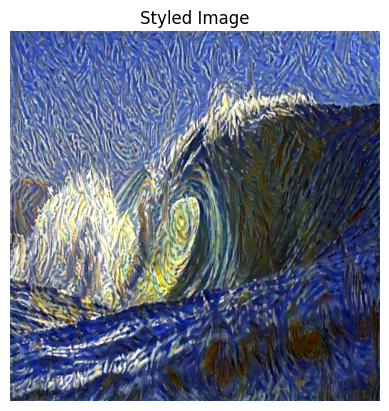

In [68]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Processing
img_size = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to Load Image
def load_img(path):
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)
    return img.to(device)

# Convert Tensor to Image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# Loss Functions
def get_content_loss(target, content):
    return torch.mean((target - content) ** 2)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

def get_style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# Total Variation Loss
def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

# Load Pretrained VGG Model
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.select_features = ["0", "5", "10", "19", "28"]
        self.vgg = models.vgg19(pretrained=True).features.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select_features:
                features.append(x)
        return features

# Load Model and Images
vgg = VGG().to(device)
content_img = load_img("/kaggle/input/nkjnkjnko/pexels-earano-1330219.jpg")
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")

target_img = content_img.clone().requires_grad_(True)

# Optimizer
optimizer = optim.Adam([target_img], lr=0.02)

# Hyperparameters
steps = 3000
alpha = 1
beta = 100000000000000


# Extract Features
content_features = vgg(content_img)
style_features = vgg(style_img)

# **Optimization Loop**
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    target_features = vgg(target_img)
    
    c_loss = get_content_loss(target_features[2], content_features[2])  
    s_loss = sum(get_style_loss(target, style) for target, style in zip(target_features, style_features))
   
    
    total_loss = alpha * c_loss + beta * s_loss 
    total_loss.backward()
    
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.99995  
    
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}, TV Loss = {tv_loss.item():.4f}")

# Show Final Image
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.title("Styled Image")
plt.show()

  0%|          | 7/3000 [00:00<02:16, 21.89it/s]

Step 0: Content Loss = 0.0000, Style Loss = 0.0004, TV Loss = 0.6444


  4%|▎         | 107/3000 [00:09<03:51, 12.52it/s]

Step 100: Content Loss = 9.1337, Style Loss = 0.0000, TV Loss = 0.6444


  7%|▋         | 207/3000 [00:18<03:42, 12.54it/s]

Step 200: Content Loss = 9.6993, Style Loss = 0.0000, TV Loss = 0.6444


 10%|█         | 307/3000 [00:27<03:39, 12.27it/s]

Step 300: Content Loss = 9.9599, Style Loss = 0.0000, TV Loss = 0.6444


 14%|█▎        | 407/3000 [00:36<03:34, 12.06it/s]

Step 400: Content Loss = 10.1037, Style Loss = 0.0000, TV Loss = 0.6444


 17%|█▋        | 507/3000 [00:46<03:31, 11.81it/s]

Step 500: Content Loss = 10.2101, Style Loss = 0.0000, TV Loss = 0.6444


 20%|██        | 607/3000 [00:56<03:18, 12.03it/s]

Step 600: Content Loss = 10.2951, Style Loss = 0.0000, TV Loss = 0.6444


 24%|██▎       | 707/3000 [01:05<03:06, 12.31it/s]

Step 700: Content Loss = 10.3664, Style Loss = 0.0000, TV Loss = 0.6444


 27%|██▋       | 807/3000 [01:14<02:56, 12.42it/s]

Step 800: Content Loss = 10.4252, Style Loss = 0.0000, TV Loss = 0.6444


 30%|███       | 907/3000 [01:23<02:47, 12.50it/s]

Step 900: Content Loss = 10.4765, Style Loss = 0.0000, TV Loss = 0.6444


 34%|███▎      | 1007/3000 [01:33<02:39, 12.46it/s]

Step 1000: Content Loss = 10.5229, Style Loss = 0.0000, TV Loss = 0.6444


 37%|███▋      | 1107/3000 [01:42<02:32, 12.38it/s]

Step 1100: Content Loss = 10.5642, Style Loss = 0.0000, TV Loss = 0.6444


 40%|████      | 1207/3000 [01:51<02:26, 12.28it/s]

Step 1200: Content Loss = 10.6024, Style Loss = 0.0000, TV Loss = 0.6444


 44%|████▎     | 1307/3000 [02:00<02:19, 12.14it/s]

Step 1300: Content Loss = 10.6374, Style Loss = 0.0000, TV Loss = 0.6444


 47%|████▋     | 1407/3000 [02:10<02:10, 12.23it/s]

Step 1400: Content Loss = 10.6699, Style Loss = 0.0000, TV Loss = 0.6444


 50%|█████     | 1507/3000 [02:19<02:01, 12.29it/s]

Step 1500: Content Loss = 10.6996, Style Loss = 0.0000, TV Loss = 0.6444


 54%|█████▎    | 1607/3000 [02:28<01:52, 12.33it/s]

Step 1600: Content Loss = 10.7275, Style Loss = 0.0000, TV Loss = 0.6444


 57%|█████▋    | 1707/3000 [02:38<01:44, 12.36it/s]

Step 1700: Content Loss = 10.7536, Style Loss = 0.0000, TV Loss = 0.6444


 60%|██████    | 1807/3000 [02:47<01:36, 12.36it/s]

Step 1800: Content Loss = 10.7781, Style Loss = 0.0000, TV Loss = 0.6444


 64%|██████▎   | 1907/3000 [02:56<01:28, 12.35it/s]

Step 1900: Content Loss = 10.8011, Style Loss = 0.0000, TV Loss = 0.6444


 67%|██████▋   | 2007/3000 [03:05<01:20, 12.36it/s]

Step 2000: Content Loss = 10.8233, Style Loss = 0.0000, TV Loss = 0.6444


 70%|███████   | 2107/3000 [03:15<01:12, 12.34it/s]

Step 2100: Content Loss = 10.8450, Style Loss = 0.0000, TV Loss = 0.6444


 74%|███████▎  | 2207/3000 [03:24<01:04, 12.35it/s]

Step 2200: Content Loss = 10.8667, Style Loss = 0.0000, TV Loss = 0.6444


 77%|███████▋  | 2307/3000 [03:33<00:56, 12.35it/s]

Step 2300: Content Loss = 10.8872, Style Loss = 0.0000, TV Loss = 0.6444


 80%|████████  | 2407/3000 [03:42<00:48, 12.32it/s]

Step 2400: Content Loss = 10.9089, Style Loss = 0.0000, TV Loss = 0.6444


 84%|████████▎ | 2507/3000 [03:52<00:39, 12.35it/s]

Step 2500: Content Loss = 10.9300, Style Loss = 0.0000, TV Loss = 0.6444


 87%|████████▋ | 2607/3000 [04:01<00:31, 12.34it/s]

Step 2600: Content Loss = 10.9496, Style Loss = 0.0000, TV Loss = 0.6444


 90%|█████████ | 2707/3000 [04:10<00:23, 12.38it/s]

Step 2700: Content Loss = 10.9655, Style Loss = 0.0000, TV Loss = 0.6444


 94%|█████████▎| 2807/3000 [04:19<00:15, 12.36it/s]

Step 2800: Content Loss = 10.9800, Style Loss = 0.0000, TV Loss = 0.6444


 97%|█████████▋| 2907/3000 [04:29<00:07, 12.36it/s]

Step 2900: Content Loss = 10.9916, Style Loss = 0.0000, TV Loss = 0.6444


100%|██████████| 3000/3000 [04:37<00:00, 10.80it/s]


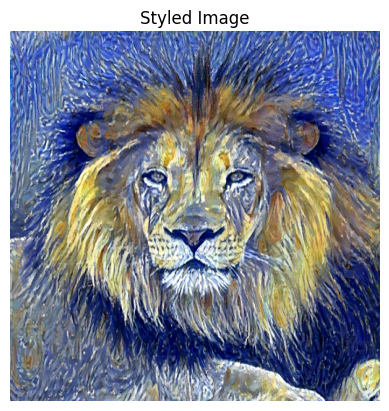

In [72]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Processing
img_size = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to Load Image
def load_img(path):
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)
    return img.to(device)

# Convert Tensor to Image
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# Loss Functions
def get_content_loss(target, content):
    return torch.mean((target - content) ** 2)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

def get_style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

# Total Variation Loss
def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

# Load Pretrained VGG Model
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.select_features = ["0", "5", "10", "19", "28"]
        self.vgg = models.vgg19(pretrained=True).features.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select_features:
                features.append(x)
        return features

# Load Model and Images
vgg = VGG().to(device)
content_img = load_img("/kaggle/input/lionak/istockphoto-182474476-612x612.jpg")
style_img = load_img("/kaggle/input/neuralstyle/van.jpg")

target_img = content_img.clone().requires_grad_(True)

# Optimizer
optimizer = optim.Adam([target_img], lr=0.02)

# Hyperparameters
steps = 3000
alpha = 1
beta = 10000000000000


# Extract Features
content_features = vgg(content_img)
style_features = vgg(style_img)

# **Optimization Loop**
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    target_features = vgg(target_img)
    
    c_loss = get_content_loss(target_features[2], content_features[2])  
    s_loss = sum(get_style_loss(target, style) for target, style in zip(target_features, style_features))
   
    
    total_loss = alpha * c_loss + beta * s_loss 
    total_loss.backward()
    
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.99995  
    
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}, TV Loss = {tv_loss.item():.4f}")

# Show Final Image
plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.title("Styled Image")
plt.show()

  0%|          | 7/2000 [00:00<01:32, 21.52it/s]

Step 0: Total Loss = 13761406566400.0000, Content Loss = 0.0000, Style Loss = 13.7614


  5%|▌         | 107/2000 [00:09<02:37, 12.01it/s]

Step 100: Total Loss = 6618873856000.0000, Content Loss = 3.4193, Style Loss = 6.6189


 10%|█         | 207/2000 [00:18<02:29, 12.00it/s]

Step 200: Total Loss = 5445264605184.0000, Content Loss = 4.5422, Style Loss = 5.4453


 15%|█▌        | 307/2000 [00:28<02:24, 11.70it/s]

Step 300: Total Loss = 4502805544960.0000, Content Loss = 5.2006, Style Loss = 4.5028


 20%|██        | 407/2000 [00:38<02:17, 11.58it/s]

Step 400: Total Loss = 3538510675968.0000, Content Loss = 5.6667, Style Loss = 3.5385


 25%|██▌       | 507/2000 [00:47<02:05, 11.93it/s]

Step 500: Total Loss = 2585824329728.0000, Content Loss = 6.0247, Style Loss = 2.5858


 30%|███       | 607/2000 [00:57<01:54, 12.14it/s]

Step 600: Total Loss = 1765445337088.0000, Content Loss = 6.3089, Style Loss = 1.7654


 35%|███▌      | 707/2000 [01:06<01:45, 12.25it/s]

Step 700: Total Loss = 1170524733440.0000, Content Loss = 6.5401, Style Loss = 1.1705


 40%|████      | 807/2000 [01:15<01:37, 12.26it/s]

Step 800: Total Loss = 807713898496.0000, Content Loss = 6.7338, Style Loss = 0.8077


 45%|████▌     | 907/2000 [01:25<01:29, 12.26it/s]

Step 900: Total Loss = 610142584832.0000, Content Loss = 6.9033, Style Loss = 0.6101


 50%|█████     | 1007/2000 [01:34<01:21, 12.22it/s]

Step 1000: Total Loss = 502140534784.0000, Content Loss = 7.0559, Style Loss = 0.5021


 55%|█████▌    | 1107/2000 [01:43<01:13, 12.14it/s]

Step 1100: Total Loss = 436408680448.0000, Content Loss = 7.1960, Style Loss = 0.4364


 60%|██████    | 1207/2000 [01:52<01:05, 12.11it/s]

Step 1200: Total Loss = 390887112704.0000, Content Loss = 7.3247, Style Loss = 0.3909


 65%|██████▌   | 1307/2000 [02:02<00:57, 12.07it/s]

Step 1300: Total Loss = 356048928768.0000, Content Loss = 7.4406, Style Loss = 0.3560


 70%|███████   | 1407/2000 [02:11<00:48, 12.11it/s]

Step 1400: Total Loss = 327589232640.0000, Content Loss = 7.5460, Style Loss = 0.3276


 75%|███████▌  | 1507/2000 [02:20<00:40, 12.10it/s]

Step 1500: Total Loss = 303358377984.0000, Content Loss = 7.6446, Style Loss = 0.3034


 80%|████████  | 1607/2000 [02:30<00:32, 12.17it/s]

Step 1600: Total Loss = 282002161664.0000, Content Loss = 7.7354, Style Loss = 0.2820


 85%|████████▌ | 1707/2000 [02:39<00:24, 12.20it/s]

Step 1700: Total Loss = 262689865728.0000, Content Loss = 7.8193, Style Loss = 0.2627


 90%|█████████ | 1807/2000 [02:48<00:15, 12.17it/s]

Step 1800: Total Loss = 244862943232.0000, Content Loss = 7.8983, Style Loss = 0.2449


 95%|█████████▌| 1907/2000 [02:58<00:07, 12.17it/s]

Step 1900: Total Loss = 228207820800.0000, Content Loss = 7.9733, Style Loss = 0.2282


100%|██████████| 2000/2000 [03:06<00:00, 10.71it/s]


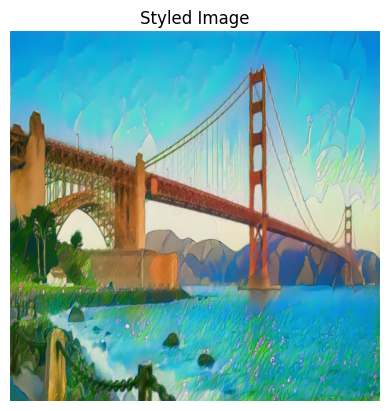

In [8]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Processing
img_size = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_img(path):
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)
    return img.to(device)

def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

def get_content_loss(target, content):
    return torch.mean((target - content) ** 2)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

def get_style_loss(target, style):
    return torch.mean((gram_matrix(target) - gram_matrix(style)) ** 2)

def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.select_features = ["0", "5", "10", "19", "28"]
        self.vgg = models.vgg19(pretrained=True).features.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select_features:
                features.append(x)
        return features

# Load Model and Images
vgg = VGG().to(device)
content_img = load_img("/kaggle/input/neuralstyle/gold.jpg")
style_img = load_img("/kaggle/input/chintu/gibi.jpg")
target_img = content_img.clone().requires_grad_(True)

optimizer = optim.Adam([target_img], lr=0.002)
steps = 2000
alpha = 1
beta = 1e12

style_weights = [1e5, 1e5, 1e5, 1e5, 1e5]

content_features = vgg(content_img)
style_features = vgg(style_img)

for step in tqdm(range(steps)):
    optimizer.zero_grad()
    target_features = vgg(target_img)
    
    c_loss = get_content_loss(target_features[2], content_features[2])
    s_loss = sum(w * get_style_loss(t, s) for w, t, s in zip(style_weights, target_features, style_features))
    
    
    total_loss = alpha * c_loss + beta * s_loss 
    total_loss.backward()
    
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.99995
    
    optimizer.step()
    target_img.data.clamp_(min=-2, max=2)  # Adjust range as needed
    
    if step % 100 == 0:
        print(f"Step {step}: Total Loss = {total_loss.item():.4f}, Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}")

plt.imshow(tensor_to_image(target_img))
plt.axis("off")
plt.title("Styled Image")
plt.show()

Step 0: Total Loss = 23082559488.0000, Content Loss = 0.0000, Style Loss = 0.0000, TV Loss = 0.2178
Step 100: Total Loss = 908368832.0000, Content Loss = 11.4177, Style Loss = 0.0000, TV Loss = 0.2631
Step 200: Total Loss = 467438880.0000, Content Loss = 13.3286, Style Loss = 0.0000, TV Loss = 0.2756
Step 300: Total Loss = 326086176.0000, Content Loss = 14.3474, Style Loss = 0.0000, TV Loss = 0.2846
Step 400: Total Loss = 255800064.0000, Content Loss = 15.0238, Style Loss = 0.0000, TV Loss = 0.2920
Step 500: Total Loss = 213756224.0000, Content Loss = 15.5059, Style Loss = 0.0000, TV Loss = 0.2984
Step 600: Total Loss = 185150192.0000, Content Loss = 15.8816, Style Loss = 0.0000, TV Loss = 0.3040
Step 700: Total Loss = 164222240.0000, Content Loss = 16.2010, Style Loss = 0.0000, TV Loss = 0.3093
Step 800: Total Loss = 148554656.0000, Content Loss = 16.4563, Style Loss = 0.0000, TV Loss = 0.3142
Step 900: Total Loss = 136089152.0000, Content Loss = 16.6712, Style Loss = 0.0000, TV Loss 

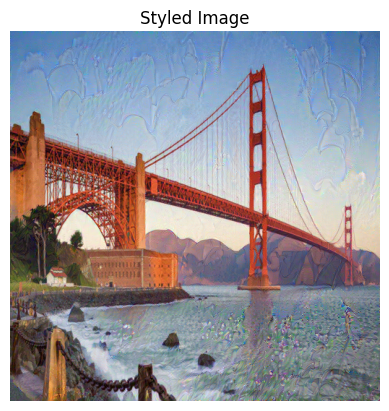

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Preprocessing
img_size = 512 if torch.cuda.is_available() else 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_img(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    return img

def tensor_to_image(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# VGG19 Encoder (Pretrained & Frozen)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.enc_layers = nn.Sequential(*list(vgg.children())[:21])  # Extract up to conv4_1
        for param in self.enc_layers.parameters():
            param.requires_grad = False  # Freeze encoder

    def forward(self, x):
        return self.enc_layers(x)

# VGG-like Decoder (Mirrored Structure)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # Reverse Conv4_1
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Reverse Conv3_1
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Reverse Conv2_1
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Reverse Conv1_1
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output range (-1,1)
        )

    def forward(self, x):
        return self.decoder(x)

# Gram Matrix for Style Loss
def gram_matrix(features):
    b, c, h, w = features.size()
    features = features.view(c, h * w)
    return torch.mm(features, features.t()) / (c * h * w)

# Loss Functions
def content_loss(gen_features, content_features):
    return torch.mean((gen_features - content_features) ** 2)

def style_loss(gen_features, style_features):
    return torch.mean((gram_matrix(gen_features) - gram_matrix(style_features)) ** 2)

def total_variation_loss(img):
    x_variation = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    y_variation = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return x_variation + y_variation

# Load Model
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Load Images
content_img = load_img("/kaggle/input/neuralstyle/gold.jpg")
style_img = load_img("/kaggle/input/chintu/gibi.jpg")

# Extract Features
content_features = encoder(content_img).detach()
style_features = encoder(style_img).detach()

# Initialize the target image for optimization
target_img = content_img.clone().requires_grad_(True)

# Optimizer (Optimizing Target Image)
optimizer = optim.Adam([target_img], lr=0.003)

# Training Loop
steps = 2000
alpha = 1  # Content Weight
beta = 1e15  # Style Weight
tv_weight = 1e-4  # Total Variation Weight

for step in range(steps):
    optimizer.zero_grad()
    
    encoded_target = encoder(target_img)
    c_loss = content_loss(encoded_target, content_features)
    s_loss = style_loss(encoded_target, style_features)
    tv_loss = total_variation_loss(target_img)
    
    total_loss = alpha * c_loss + beta * s_loss + tv_weight * tv_loss
    total_loss.backward()
    
    optimizer.step()
    
    if step % 100 == 0:
        print(f"Step {step}: Total Loss = {total_loss.item():.4f}, Content Loss = {c_loss.item():.4f}, Style Loss = {s_loss.item():.4f}, TV Loss = {tv_loss.item():.4f}")

# Show Final Stylized Image
styled_image = tensor_to_image(target_img)
plt.imshow(styled_image)
plt.axis("off")
plt.title("Styled Image")
plt.show()